# Transfer learning with PyTorch
 classifications of smiles and "antismiles" (sad faces)

## Initialization

In [1]:
%load_ext autoreload
%autoreload 2    # to automatically reload all changed code

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os


from IPython.core.debugger import set_trace   # very convenient

from pprint import pprint   # pretty print



In [4]:
''' Training  helpers, follow the tutorial of Otte (the lecturer) 
    They were written by him, and were not included in pytorch .
'''

def getTrainableParam(model):
    return (p for p in model.parameters() if p.requires_grad)


def getFrozenParam(model):
    # Actually we would prefer to freeze only the convolutional layers
    return (p for p in model.parameters() if not p.requires_grad)


def isAllTrainable(model):
    ## returns a bool
    return all(p.requires_grad for p in model.parameters() )


def isAllFrozen(model):
    ## returns a bool    
    return all(not p.requires_grad for p in model.parameters() )


def freezeAll(model, exceptLastLayer =False):
    if exceptLastLayer: 
        model = model[:-1] 
         
    for p in model.parameters():
        p.requires_grad = False


In [5]:
'''  little functions that help for handling the pytorch image tensors: 
     (written by myself  )
'''        

def haveSameChannelNbr(imagesDatasets ):
    '''  imagesDatasets  :  an iterator over the dataset, built with imageFolder, that returns a single image. 
    This function tests if every pytorch tensor that represents an image has exactly the same number of channels. 
    Default is testing for nbr =3 channels
    '''
    # index = 0 represents the number of channels
    return all(isSameSize_n(imagesDatasets,[0]))

    
def isSameSize_n(imagesDatasets,nList, isVerbose=False):
    ''' 
    nList :  list of index we regard. We check if all values are equal along the regarded dimensions 
    
    return a list of bool, one-to-one associated to nList
    '''
    
    # list of the tensor shapes of the images in the dataset:   
    tensorShapeList = [ tupl[0].numpy().shape for tupl in imagesDatasets ]      
    returnList=list()
    for n in nList:
        r = [ shape[n] == tensorShapeList[0][n] for shape in tensorShapeList]
        if isVerbose:
            print(r)
            print(all(r))
        returnList.append(all(r) )  
    return returnList
    
def areAllOfSameSize(imagesDatasets):
    '''  imagesDatasets  :  an iterator over the dataset, built with imageFolder, that returns a single image. 
         This function tests if all the dimensions (including the nbr of channels) 
         of every pytorch tensor in the dataset match. 
    '''
    # are the 3 dimensions of all the tensors equal ?
    return (  all(isSameSize_n(imagesDatasets, [0,1,2])) )
    

def countsSizeForAllTensors(imagesDatasets, dimList =[0,1,2], isVerbose=False):
    '''  
    Returns sizeDicList : a list of dictionaries that is one-to-one with dimList
        For all dimension n in dimList, the element of index n in sizeDicList 
        is a dictionary that counts the frequency of all tensor size.
    '''    
    sizeDicList = [ dict() for dim in dimList ]
    for tupl in imagesDatasets:
        for dim, sizeDic in zip(dimList,sizeDicList): 
            size = tupl[0].numpy().shape[dim]
            if isVerbose:
                print("size%i=%i" % (dim,size))
            
            if size in sizeDic.keys():    
                sizeDic[size] +=1
            else:            
                # it is the first time we 'hit' this size 
                sizeDic[size] = 1
    return sizeDicList  


def countsChannelNbr(imagesDatasets, isVerbose=False):
    '''
    return a dictionary that counts the number of channels for each tensor
    '''
    #index =0 : the index that represents the number of channels 
    sizeDicList = countsSizeForAllTensors(imagesDatasets, [0] )
    if isVerbose: print('number of channels: %s'%sizeDicList)
    
    channelNbrDict = sizeDicList[0]    
    return channelNbrDict 


# The Data

In [6]:
_image_size = 256 
_channelNbr = 3

## Transforms

In [7]:
from torchvision import transforms 

## OK in several tutorials, they just dont change these values.. So we just keep them too. 
_mean = [0.485, 0.456, 0.406]   # channels RGB 
_std  = [0.229, 0.224, 0.225]    


## Transformations for training:  for Data augmentation 
# The mouth is assumed to be entirely visible (NO random crop)
transf = {'train': None, 'val':None,'test': None}

#horizontal and vertical axes of the pictures can be exchanged, so we must have this invariance
transf['train'] = transforms.Compose([
    transforms.Resize(256),  # some images are that small
    transforms.RandomRotation(90),
    transforms.RandomVerticalFlip(0.5),  
    transforms.RandomHorizontalFlip(0.5),
    transforms.CenterCrop(_image_size),
    transforms.ColorJitter(.3, .3, .3),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std), ])

## transformation for test and validation  
for x in ['val','test']:
    transf[x] = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(_image_size),
        transforms.ToTensor(),
        transforms.Normalize(_mean, _std), ])
    


## The dataset: we have 2 classes :smile   vs antiSmile 

In [8]:
from torchvision.datasets import ImageFolder

rootDir = os.path.split(os.getcwd())[0]
datasetDir = os.path.join(rootDir, 'mimiquesDataset')

#classNames = ['smiles','antiSmiles']
#nClasses = len(classNames)

## train/val/test  manually splitting in the rootDir 
dirs = ['train', 'val', 'test']

# dictionary that returns the path, for the directory of each class  
pathDic = {d: os.path.join(datasetDir,d) for d in dirs } 

In [9]:
##  imageFolder iterators over dataset and dataset size for train, val, test, 
imagesDatasets = {d:ImageFolder( pathDic[d], transform = transf[d]) for d in ['train', 'val', 'test']}
datasetSize    = {d: len(imagesDatasets[d])  for d in ['train', 'val', 'test']}

classNames = imagesDatasets['train'].classes
nClasses = len(classNames)

## Some checking about the tensors 

In [10]:
## All image tensors have same size and same number of channels :
isVerbose =False
print( isSameSize_n(imagesDatasets['train'], [0,1,2],  isVerbose ) )

print( 'Are all images of same size?: %s'%areAllOfSameSize(imagesDatasets['train'])  )



[True, True, True]
Are all images of same size?: True


In [11]:
channelNbrDict, size1Dic, size2Dic =countsSizeForAllTensors(imagesDatasets['train'])
s1, s2 = list(size1Dic.keys())[0], list(size2Dic.keys())[0]
print('The size of all tensors that represent the images is: %s x %s\n'%(s1, s2 )  )


# We check if the channel number is 3, as specified above (  since _channelNbr =3)
doAllTensorsHave3Channels = all([ (_channelNbr == c) for c in channelNbrDict.keys()])
print('Do all tensors have 3 channels?: %s'% doAllTensorsHave3Channels )

The size of all tensors that represent the images is: 256 x 256

Do all tensors have 3 channels?: True


####  Automatical splitting (eventually for cross-validation)

In [12]:
from torch.utils.data import random_split
'''https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
   https://github.com/ncullen93/torchsample/blob/master/torchsample/samplers.py#L22\
   https://stackoverflow.com/questions/3674409/how-to-split-partition-a-dataset-into-training-and-test-datasets-for-e-g-cros
'''

'''blablabla
random_split(full_dataset, [train_size, test_size])
'''

'blablabla\nrandom_split(full_dataset, [train_size, test_size])\n'

## DataLoader
Batch loading for datasets with multi-processing

In [13]:
from torch.utils.data import DataLoader 
num_workers =2
batch_size =32

train_dl = DataLoader(
    imagesDatasets['train'],
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,)

val_dl = DataLoader(
    imagesDatasets['val'],
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,)

test_dl = DataLoader(
    imagesDatasets['test'],   
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,)


## Show some images


In [14]:
def showImage(image, mean =_mean, std = _std):
    
    if isinstance(image,torch.Tensor):
        image =image.numpy()
    else: 
        image = np.array(image)
    image = image.transpose((1,2,0)) 
    
                             
    ## Unormalization
    mean = np.array(_mean)
    std = np.array(_std)
    image = std*image + mean 
    image = np.clip(image,0,1)
    
    ## plot
    fig, ax = plt.subplots(1,1, figsize=[20,20])
    plt.imshow(image)
    ax.axis('off')

    
def showNextBatchImages(downloader, ncol =batch_size):
    '''Show the images of the next batch in the dataloader iterator
     The batch size must be divisible by ncol (number of column) i.e. batch_size = ncol * nrow 
    '''
    images, _ = next(iter(train_dl))
    image = torchvision.utils.make_grid(images, ncol)                     
    showImage(image)      

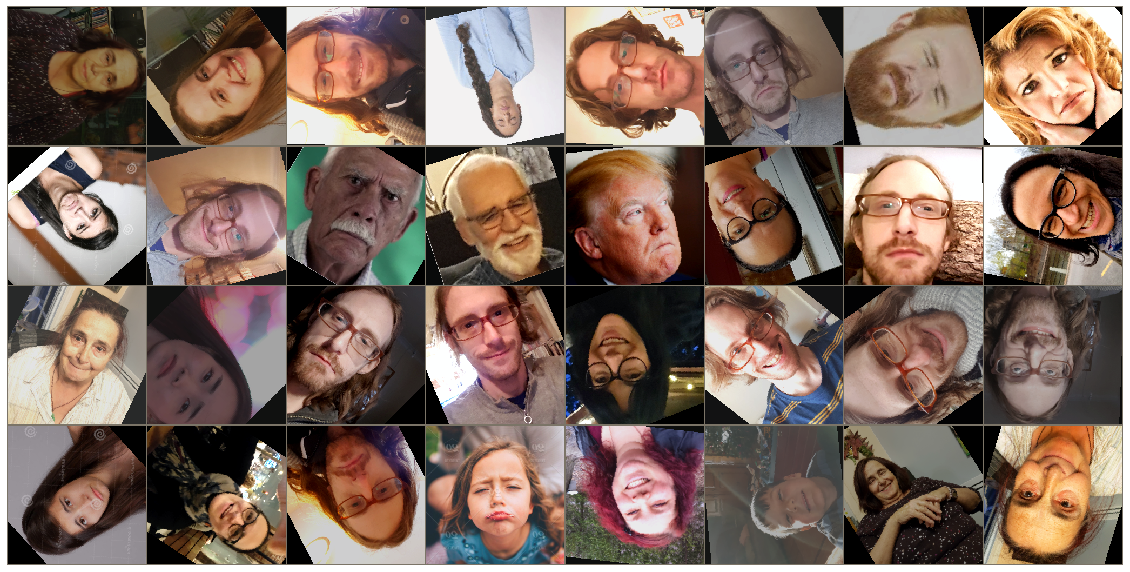

In [15]:
showNextBatchImages(train_dl, 8)

# The Model
( https://pytorch.org/docs/stable/torchvision/models.html)
We can try many architectures with pretrained weights such that AlexNet, VGG, ResNet18, ...

In [16]:
from torchvision import models

# https://pypi.org/project/torchsummary/
# Model summary in PyTorch similar to `model.summary()` in Keras
# explanation avec comparison with keras:  https://towardsdatascience.com/model-summary-in-pytorch-b5a1e4b64d25
import torchsummary      


In [17]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def getModel(nClasses=nClasses):
    
    ## the frozen model: resnet18 :  67 layers
    model = models.resnet18(pretrained=True)
    freezeAll(model)
    assert isAllFrozen(model)
    
    ## adding a trainable layer 
    linearNbr = 512  
    model.fc = nn.Linear(linearNbr, nClasses)
    assert not isAllFrozen(model)
    
    return model.to(DEVICE)


In [18]:
model = getModel()

In [19]:
torchsummary.summary(model, (_channelNbr, _image_size, _image_size))   

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

# The Loss

In [20]:
criterion =nn.CrossEntropyLoss() 



# nn.NLLLoss()   # MUST ADD A SOFTMAX LAYER with NLLoss() 
# The loss function nn.CrossEntropyLoss() already includes the softmax, 
# and it is why the pytorch code for transfer learning does not add this layer. 
# Of course for other loss functions as negative log-likelihood,
# we must add a softmax activation function after the FC linear

##  Et comment on ajouterait un terme de regulariation 

# The Optimizer

In [21]:
## we optimize only the last layer .
optimizer = torch.optim.Adam(getTrainableParam(model), lr=0.0001,) 


#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, 
#                            momentum=0.9,
#                            weight_decay=1e-4)


# Training and evaluation

In [23]:
N_EPOCHS = 1000

for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    
    # Train
    model.train()  
    
    running_loss, correct = 0.0, 0
    for X, y in train_dl:
        X, y = X.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        y_ = model(X)
        loss = criterion(y_, y)
        loss.backward()
        optimizer.step()
        
        # Statistics
        print(f"    batch loss: {loss.item():0.3f}")
        _, y_label_ = torch.max(y_, 1)
        correct += (y_label_ == y).sum().item()
        running_loss += loss.item() * X.shape[0]
    
    print(f"  Train Loss: {running_loss / len(train_dl.dataset)}")
    print(f"  Train Acc:  {correct / len(train_dl.dataset)}")
    
    
    # Eval
    model.eval()  
    
    running_loss, correct = 0.0, 0
    with torch.no_grad():  
        for X, y in val_dl:
            X, y = X.to(DEVICE), y.to(DEVICE)
                    
            y_ = model(X)
        
            # Statistics
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
    
    print(f"  Valid Loss: {running_loss / len(val_dl.dataset)}")
    print(f"  Valid Acc:  {correct / len(val_dl.dataset)}")
    

Epoch 1/1000
    batch loss: 0.443
    batch loss: 0.444
    batch loss: 0.430
  Train Loss: 0.4400566921514623
  Train Acc:  0.788235294117647
  Valid Loss: 0.5141001343727112
  Valid Acc:  0.6666666666666666
Epoch 2/1000
    batch loss: 0.447
    batch loss: 0.372
    batch loss: 0.418
  Train Loss: 0.4118264825905071
  Train Acc:  0.8235294117647058
  Valid Loss: 0.5217934250831604
  Valid Acc:  0.6666666666666666
Epoch 3/1000
    batch loss: 0.385
    batch loss: 0.367
    batch loss: 0.263
  Train Loss: 0.3479983890757841
  Train Acc:  0.8705882352941177
  Valid Loss: 0.5157580375671387
  Valid Acc:  0.6666666666666666
Epoch 4/1000
    batch loss: 0.441
    batch loss: 0.325
    batch loss: 0.397
  Train Loss: 0.38645788255859825
  Train Acc:  0.8470588235294118
  Valid Loss: 0.5179362297058105
  Valid Acc:  0.6666666666666666
Epoch 5/1000
    batch loss: 0.424
    batch loss: 0.276
    batch loss: 0.489
  Train Loss: 0.38453474360353807
  Train Acc:  0.8705882352941177
  Valid Lo

    batch loss: 0.424
    batch loss: 0.325
    batch loss: 0.461
  Train Loss: 0.39579973992179424
  Train Acc:  0.8352941176470589
  Valid Loss: 0.507866621017456
  Valid Acc:  0.6666666666666666
Epoch 41/1000
    batch loss: 0.376
    batch loss: 0.348
    batch loss: 0.408
  Train Loss: 0.3732781441772685
  Train Acc:  0.8823529411764706
  Valid Loss: 0.5044276118278503
  Valid Acc:  0.6666666666666666
Epoch 42/1000
    batch loss: 0.387
    batch loss: 0.431
    batch loss: 0.280
  Train Loss: 0.3772091897094951
  Train Acc:  0.8588235294117647
  Valid Loss: 0.5055223703384399
  Valid Acc:  0.6666666666666666
Epoch 43/1000
    batch loss: 0.434
    batch loss: 0.443
    batch loss: 0.373
  Train Loss: 0.4224495852694792
  Train Acc:  0.788235294117647
  Valid Loss: 0.518151044845581
  Valid Acc:  0.6666666666666666
Epoch 44/1000
    batch loss: 0.428
    batch loss: 0.385
    batch loss: 0.330
  Train Loss: 0.38731934358091913
  Train Acc:  0.8117647058823529
  Valid Loss: 0.52044

    batch loss: 0.408
    batch loss: 0.398
    batch loss: 0.294
  Train Loss: 0.3760536176316878
  Train Acc:  0.8470588235294118
  Valid Loss: 0.5041259527206421
  Valid Acc:  0.6666666666666666
Epoch 80/1000
    batch loss: 0.360
    batch loss: 0.421
    batch loss: 0.286
  Train Loss: 0.3647579217658323
  Train Acc:  0.8588235294117647
  Valid Loss: 0.5001906156539917
  Valid Acc:  0.6666666666666666
Epoch 81/1000
    batch loss: 0.332
    batch loss: 0.363
    batch loss: 0.260
  Train Loss: 0.3258504246964174
  Train Acc:  0.8588235294117647
  Valid Loss: 0.5062577128410339
  Valid Acc:  0.6666666666666666
Epoch 82/1000
    batch loss: 0.418
    batch loss: 0.501
    batch loss: 0.414
  Train Loss: 0.44798242730252885
  Train Acc:  0.7647058823529411
  Valid Loss: 0.5079115629196167
  Valid Acc:  0.6666666666666666
Epoch 83/1000
    batch loss: 0.365
    batch loss: 0.299
    batch loss: 0.384
  Train Loss: 0.34474192156511196
  Train Acc:  0.8705882352941177
  Valid Loss: 0.51

  Valid Loss: 0.5134852528572083
  Valid Acc:  0.7222222222222222
Epoch 118/1000
    batch loss: 0.334
    batch loss: 0.353
    batch loss: 0.554
  Train Loss: 0.3952708356520709
  Train Acc:  0.8235294117647058
  Valid Loss: 0.5002689957618713
  Valid Acc:  0.6666666666666666
Epoch 119/1000
    batch loss: 0.311
    batch loss: 0.427
    batch loss: 0.487
  Train Loss: 0.3982124111231636
  Train Acc:  0.8235294117647058
  Valid Loss: 0.4996488392353058
  Valid Acc:  0.6666666666666666
Epoch 120/1000
    batch loss: 0.381
    batch loss: 0.365
    batch loss: 0.402
  Train Loss: 0.3798588819363538
  Train Acc:  0.8
  Valid Loss: 0.5142611265182495
  Valid Acc:  0.7222222222222222
Epoch 121/1000
    batch loss: 0.314
    batch loss: 0.391
    batch loss: 0.440
  Train Loss: 0.3740738244617687
  Train Acc:  0.8352941176470589
  Valid Loss: 0.5135414004325867
  Valid Acc:  0.7222222222222222
Epoch 122/1000
    batch loss: 0.398
    batch loss: 0.329
    batch loss: 0.395
  Train Loss: 0.

    batch loss: 0.355
  Train Loss: 0.37118707684909596
  Train Acc:  0.8470588235294118
  Valid Loss: 0.48717397451400757
  Valid Acc:  0.6666666666666666
Epoch 157/1000
    batch loss: 0.266
    batch loss: 0.384
    batch loss: 0.455
  Train Loss: 0.3572570355499492
  Train Acc:  0.8705882352941177
  Valid Loss: 0.4939148724079132
  Valid Acc:  0.6666666666666666
Epoch 158/1000
    batch loss: 0.410
    batch loss: 0.305
    batch loss: 0.433
  Train Loss: 0.376111303357517
  Train Acc:  0.8470588235294118
  Valid Loss: 0.49303606152534485
  Valid Acc:  0.6666666666666666
Epoch 159/1000
    batch loss: 0.316
    batch loss: 0.448
    batch loss: 0.432
  Train Loss: 0.3942433160894057
  Train Acc:  0.8470588235294118
  Valid Loss: 0.4885658621788025
  Valid Acc:  0.6666666666666666
Epoch 160/1000
    batch loss: 0.337
    batch loss: 0.390
    batch loss: 0.392
  Train Loss: 0.37040055394172666
  Train Acc:  0.8588235294117647
  Valid Loss: 0.5039233565330505
  Valid Acc:  0.66666666

    batch loss: 0.353
    batch loss: 0.387
    batch loss: 0.407
  Train Loss: 0.3792800784111023
  Train Acc:  0.8470588235294118
  Valid Loss: 0.4864800274372101
  Valid Acc:  0.6666666666666666
Epoch 196/1000
    batch loss: 0.276
    batch loss: 0.389
    batch loss: 0.385
  Train Loss: 0.34558813712176156
  Train Acc:  0.8823529411764706
  Valid Loss: 0.4962514638900757
  Valid Acc:  0.6666666666666666
Epoch 197/1000
    batch loss: 0.384
    batch loss: 0.327
    batch loss: 0.385
  Train Loss: 0.36282851625891294
  Train Acc:  0.8470588235294118
  Valid Loss: 0.49654966592788696
  Valid Acc:  0.6666666666666666
Epoch 198/1000
    batch loss: 0.267
    batch loss: 0.307
    batch loss: 0.305
  Train Loss: 0.2913573612185085
  Train Acc:  0.8823529411764706
  Valid Loss: 0.4949250817298889
  Valid Acc:  0.6666666666666666
Epoch 199/1000
    batch loss: 0.307
    batch loss: 0.382
    batch loss: 0.222
  Train Loss: 0.31433549225330354
  Train Acc:  0.9058823529411765
  Valid Loss

  Valid Loss: 0.48717033863067627
  Valid Acc:  0.6666666666666666
Epoch 234/1000
    batch loss: 0.465
    batch loss: 0.306
    batch loss: 0.340
  Train Loss: 0.3744070144260631
  Train Acc:  0.8705882352941177
  Valid Loss: 0.49072277545928955
  Valid Acc:  0.6666666666666666
Epoch 235/1000
    batch loss: 0.394
    batch loss: 0.238
    batch loss: 0.412
  Train Loss: 0.3396175577360041
  Train Acc:  0.8823529411764706
  Valid Loss: 0.4877351224422455
  Valid Acc:  0.6666666666666666
Epoch 236/1000
    batch loss: 0.406
    batch loss: 0.414
    batch loss: 0.373
  Train Loss: 0.40068932491190296
  Train Acc:  0.8352941176470589
  Valid Loss: 0.48680004477500916
  Valid Acc:  0.6666666666666666
Epoch 237/1000
    batch loss: 0.352
    batch loss: 0.291
    batch loss: 0.308
  Train Loss: 0.3181192201726577
  Train Acc:  0.8941176470588236
  Valid Loss: 0.49820148944854736
  Valid Acc:  0.6666666666666666
Epoch 238/1000
    batch loss: 0.382
    batch loss: 0.281
    batch loss: 0.

    batch loss: 0.271
  Train Loss: 0.35342638352338007
  Train Acc:  0.8705882352941177
  Valid Loss: 0.49463409185409546
  Valid Acc:  0.6666666666666666
Epoch 273/1000
    batch loss: 0.349
    batch loss: 0.392
    batch loss: 0.311
  Train Loss: 0.35588412144604853
  Train Acc:  0.8352941176470589
  Valid Loss: 0.5015960931777954
  Valid Acc:  0.6666666666666666
Epoch 274/1000
    batch loss: 0.425
    batch loss: 0.317
    batch loss: 0.305
  Train Loss: 0.35454924141659455
  Train Acc:  0.8588235294117647
  Valid Loss: 0.508928120136261
  Valid Acc:  0.6666666666666666
Epoch 275/1000
    batch loss: 0.329
    batch loss: 0.280
    batch loss: 0.322
  Train Loss: 0.3089844458243426
  Train Acc:  0.8588235294117647
  Valid Loss: 0.5082554221153259
  Valid Acc:  0.6666666666666666
Epoch 276/1000
    batch loss: 0.409
    batch loss: 0.381
    batch loss: 0.330
  Train Loss: 0.3786242600749521
  Train Acc:  0.8705882352941177
  Valid Loss: 0.5102130174636841
  Valid Acc:  0.66666666

    batch loss: 0.328
    batch loss: 0.382
    batch loss: 0.265
  Train Loss: 0.3328563094139099
  Train Acc:  0.8705882352941177
  Valid Loss: 0.5090115070343018
  Valid Acc:  0.6666666666666666
Epoch 312/1000
    batch loss: 0.365
    batch loss: 0.269
    batch loss: 0.320
  Train Loss: 0.31783883922240314
  Train Acc:  0.8941176470588236
  Valid Loss: 0.497639924287796
  Valid Acc:  0.6666666666666666
Epoch 313/1000
    batch loss: 0.293
    batch loss: 0.255
    batch loss: 0.342
  Train Loss: 0.2906628668308258
  Train Acc:  0.9176470588235294
  Valid Loss: 0.4981846809387207
  Valid Acc:  0.6666666666666666
Epoch 314/1000
    batch loss: 0.233
    batch loss: 0.325
    batch loss: 0.365
  Train Loss: 0.30018845901769753
  Train Acc:  0.8823529411764706
  Valid Loss: 0.49855682253837585
  Valid Acc:  0.6666666666666666
Epoch 315/1000
    batch loss: 0.308
    batch loss: 0.337
    batch loss: 0.418
  Train Loss: 0.34605937494951133
  Train Acc:  0.8352941176470589
  Valid Loss:

  Valid Loss: 0.5109434127807617
  Valid Acc:  0.7222222222222222
Epoch 350/1000
    batch loss: 0.282
    batch loss: 0.411
    batch loss: 0.293
  Train Loss: 0.33329548415015725
  Train Acc:  0.8470588235294118
  Valid Loss: 0.5091119408607483
  Valid Acc:  0.7222222222222222
Epoch 351/1000
    batch loss: 0.316
    batch loss: 0.377
    batch loss: 0.427
  Train Loss: 0.3662993592374465
  Train Acc:  0.8705882352941177
  Valid Loss: 0.502637505531311
  Valid Acc:  0.7222222222222222
Epoch 352/1000
    batch loss: 0.392
    batch loss: 0.307
    batch loss: 0.384
  Train Loss: 0.35794156859902776
  Train Acc:  0.8470588235294118
  Valid Loss: 0.510585606098175
  Valid Acc:  0.7222222222222222
Epoch 353/1000
    batch loss: 0.194
    batch loss: 0.391
    batch loss: 0.288
  Train Loss: 0.2911623092258678
  Train Acc:  0.9058823529411765
  Valid Loss: 0.5135545134544373
  Valid Acc:  0.7222222222222222
Epoch 354/1000
    batch loss: 0.262
    batch loss: 0.362
    batch loss: 0.437
 

    batch loss: 0.279
    batch loss: 0.307
  Train Loss: 0.33746120473917796
  Train Acc:  0.8470588235294118
  Valid Loss: 0.4936668574810028
  Valid Acc:  0.6666666666666666
Epoch 389/1000
    batch loss: 0.395
    batch loss: 0.332
    batch loss: 0.260
  Train Loss: 0.3378427649245543
  Train Acc:  0.8352941176470589
  Valid Loss: 0.47721877694129944
  Valid Acc:  0.6666666666666666
Epoch 390/1000
    batch loss: 0.323
    batch loss: 0.416
    batch loss: 0.262
  Train Loss: 0.3428020659615012
  Train Acc:  0.8705882352941177
  Valid Loss: 0.48606550693511963
  Valid Acc:  0.6666666666666666
Epoch 391/1000
    batch loss: 0.456
    batch loss: 0.286
    batch loss: 0.274
  Train Loss: 0.3470337450504303
  Train Acc:  0.8588235294117647
  Valid Loss: 0.48597845435142517
  Valid Acc:  0.6666666666666666
Epoch 392/1000
    batch loss: 0.372
    batch loss: 0.323
    batch loss: 0.466
  Train Loss: 0.3768619235824136
  Train Acc:  0.8352941176470589
  Valid Loss: 0.48013243079185486


  Valid Loss: 0.5002402067184448
  Valid Acc:  0.6666666666666666
Epoch 427/1000
    batch loss: 0.291
    batch loss: 0.264
    batch loss: 0.211
  Train Loss: 0.2610612036550746
  Train Acc:  0.9058823529411765
  Valid Loss: 0.5025908946990967
  Valid Acc:  0.7222222222222222
Epoch 428/1000
    batch loss: 0.321
    batch loss: 0.251
    batch loss: 0.362
  Train Loss: 0.3046182797235601
  Train Acc:  0.9058823529411765
  Valid Loss: 0.4916020631790161
  Valid Acc:  0.6666666666666666
Epoch 429/1000
    batch loss: 0.245
    batch loss: 0.359
    batch loss: 0.374
  Train Loss: 0.3201492653173559
  Train Acc:  0.8705882352941177
  Valid Loss: 0.5021928548812866
  Valid Acc:  0.7222222222222222
Epoch 430/1000
    batch loss: 0.282
    batch loss: 0.338
    batch loss: 0.399
  Train Loss: 0.332076297788059
  Train Acc:  0.8823529411764706
  Valid Loss: 0.48863962292671204
  Valid Acc:  0.6666666666666666
Epoch 431/1000
    batch loss: 0.291
    batch loss: 0.278
    batch loss: 0.345
 

    batch loss: 0.350
    batch loss: 0.379
    batch loss: 0.297
  Train Loss: 0.3476973782567417
  Train Acc:  0.8470588235294118
  Valid Loss: 0.4871153235435486
  Valid Acc:  0.7222222222222222
Epoch 466/1000
    batch loss: 0.159
    batch loss: 0.359
    batch loss: 0.347
  Train Loss: 0.2804904401302338
  Train Acc:  0.8705882352941177
  Valid Loss: 0.4791887104511261
  Valid Acc:  0.6666666666666666
Epoch 467/1000
    batch loss: 0.227
    batch loss: 0.250
    batch loss: 0.383
  Train Loss: 0.2738899206413942
  Train Acc:  0.8823529411764706
  Valid Loss: 0.46712833642959595
  Valid Acc:  0.6666666666666666
Epoch 468/1000
    batch loss: 0.298
    batch loss: 0.361
    batch loss: 0.396
  Train Loss: 0.3458263043095084
  Train Acc:  0.8705882352941177
  Valid Loss: 0.4745473265647888
  Valid Acc:  0.6666666666666666
Epoch 469/1000
    batch loss: 0.291
    batch loss: 0.254
    batch loss: 0.280
  Train Loss: 0.2743391464738285
  Train Acc:  0.8823529411764706
  Valid Loss: 0

  Valid Loss: 0.4638054668903351
  Valid Acc:  0.6666666666666666
Epoch 504/1000
    batch loss: 0.328
    batch loss: 0.311
    batch loss: 0.241
  Train Loss: 0.3000185589579975
  Train Acc:  0.9058823529411765
  Valid Loss: 0.482231080532074
  Valid Acc:  0.7222222222222222
Epoch 505/1000
    batch loss: 0.263
    batch loss: 0.322
    batch loss: 0.357
  Train Loss: 0.3088252207812141
  Train Acc:  0.8823529411764706
  Valid Loss: 0.4962726831436157
  Valid Acc:  0.7222222222222222
Epoch 506/1000
    batch loss: 0.185
    batch loss: 0.334
    batch loss: 0.438
  Train Loss: 0.3038095621501698
  Train Acc:  0.8823529411764706
  Valid Loss: 0.4925924837589264
  Valid Acc:  0.7222222222222222
Epoch 507/1000
    batch loss: 0.282
    batch loss: 0.260
    batch loss: 0.231
  Train Loss: 0.2610444237204159
  Train Acc:  0.9176470588235294
  Valid Loss: 0.4952353835105896
  Valid Acc:  0.7222222222222222
Epoch 508/1000
    batch loss: 0.381
    batch loss: 0.265
    batch loss: 0.328
  

    batch loss: 0.187
    batch loss: 0.347
    batch loss: 0.326
  Train Loss: 0.2812759189044728
  Train Acc:  0.9058823529411765
  Valid Loss: 0.4906328022480011
  Valid Acc:  0.7222222222222222
Epoch 543/1000
    batch loss: 0.304
    batch loss: 0.294
    batch loss: 0.323
  Train Loss: 0.30490171383408937
  Train Acc:  0.8705882352941177
  Valid Loss: 0.49595293402671814
  Valid Acc:  0.7222222222222222
Epoch 544/1000
    batch loss: 0.269
    batch loss: 0.342
    batch loss: 0.248
  Train Loss: 0.2912582953186596
  Train Acc:  0.9176470588235294
  Valid Loss: 0.5049954652786255
  Valid Acc:  0.7222222222222222
Epoch 545/1000
    batch loss: 0.249
    batch loss: 0.321
    batch loss: 0.322
  Train Loss: 0.2941267441300785
  Train Acc:  0.8941176470588236
  Valid Loss: 0.498362272977829
  Valid Acc:  0.7222222222222222
Epoch 546/1000
    batch loss: 0.332
    batch loss: 0.238
    batch loss: 0.273
  Train Loss: 0.2819552116534289
  Train Acc:  0.8705882352941177
  Valid Loss: 0

  Valid Loss: 0.5162428021430969
  Valid Acc:  0.7222222222222222
Epoch 581/1000
    batch loss: 0.259
    batch loss: 0.305
    batch loss: 0.326
  Train Loss: 0.29310521834036884
  Train Acc:  0.8705882352941177
  Valid Loss: 0.5055882334709167
  Valid Acc:  0.7222222222222222
Epoch 582/1000
    batch loss: 0.211
    batch loss: 0.354
    batch loss: 0.220
  Train Loss: 0.2667935650138294
  Train Acc:  0.9058823529411765
  Valid Loss: 0.5047937035560608
  Valid Acc:  0.7222222222222222
Epoch 583/1000
    batch loss: 0.407
    batch loss: 0.352
    batch loss: 0.325
  Train Loss: 0.36595461508807015
  Train Acc:  0.8235294117647058
  Valid Loss: 0.5140098929405212
  Valid Acc:  0.7222222222222222
Epoch 584/1000
    batch loss: 0.325
    batch loss: 0.314
    batch loss: 0.467
  Train Loss: 0.35571845419266646
  Train Acc:  0.8470588235294118
  Valid Loss: 0.5171849727630615
  Valid Acc:  0.7222222222222222
Epoch 585/1000
    batch loss: 0.243
    batch loss: 0.226
    batch loss: 0.50

    batch loss: 0.228
    batch loss: 0.235
    batch loss: 0.330
  Train Loss: 0.2560127293362337
  Train Acc:  0.9058823529411765
  Valid Loss: 0.4916861355304718
  Valid Acc:  0.7222222222222222
Epoch 620/1000
    batch loss: 0.349
    batch loss: 0.349
    batch loss: 0.263
  Train Loss: 0.3278705796774696
  Train Acc:  0.8588235294117647
  Valid Loss: 0.49538755416870117
  Valid Acc:  0.7222222222222222
Epoch 621/1000
    batch loss: 0.341
    batch loss: 0.194
    batch loss: 0.367
  Train Loss: 0.2920687777154586
  Train Acc:  0.8588235294117647
  Valid Loss: 0.4940817654132843
  Valid Acc:  0.7222222222222222
Epoch 622/1000
    batch loss: 0.357
    batch loss: 0.242
    batch loss: 0.275
  Train Loss: 0.2936887776150423
  Train Acc:  0.8352941176470589
  Valid Loss: 0.5009675621986389
  Valid Acc:  0.7222222222222222
Epoch 623/1000
    batch loss: 0.403
    batch loss: 0.276
    batch loss: 0.361
  Train Loss: 0.344529402256012
  Train Acc:  0.8823529411764706
  Valid Loss: 0.

  Valid Loss: 0.48734650015830994
  Valid Acc:  0.7222222222222222
Epoch 658/1000
    batch loss: 0.313
    batch loss: 0.309
    batch loss: 0.199
  Train Loss: 0.2834656562875299
  Train Acc:  0.8823529411764706
  Valid Loss: 0.4942053556442261
  Valid Acc:  0.7222222222222222
Epoch 659/1000
    batch loss: 0.292
    batch loss: 0.270
    batch loss: 0.339
  Train Loss: 0.29531798432855044
  Train Acc:  0.9058823529411765
  Valid Loss: 0.49530208110809326
  Valid Acc:  0.7222222222222222
Epoch 660/1000
    batch loss: 0.273
    batch loss: 0.427
    batch loss: 0.225
  Train Loss: 0.31907279456363
  Train Acc:  0.8470588235294118
  Valid Loss: 0.5049811005592346
  Valid Acc:  0.7222222222222222
Epoch 661/1000
    batch loss: 0.256
    batch loss: 0.213
    batch loss: 0.349
  Train Loss: 0.262531456526588
  Train Acc:  0.8941176470588236
  Valid Loss: 0.4907926321029663
  Valid Acc:  0.7222222222222222
Epoch 662/1000
    batch loss: 0.429
    batch loss: 0.283
    batch loss: 0.305
 

    batch loss: 0.338
    batch loss: 0.267
    batch loss: 0.185
  Train Loss: 0.2734298152082107
  Train Acc:  0.8941176470588236
  Valid Loss: 0.4952886402606964
  Valid Acc:  0.7222222222222222
Epoch 697/1000
    batch loss: 0.281
    batch loss: 0.268
    batch loss: 0.275
  Train Loss: 0.2746724654646481
  Train Acc:  0.9058823529411765
  Valid Loss: 0.48600447177886963
  Valid Acc:  0.7222222222222222
Epoch 698/1000
    batch loss: 0.222
    batch loss: 0.319
    batch loss: 0.334
  Train Loss: 0.28621757977149065
  Train Acc:  0.8823529411764706
  Valid Loss: 0.4924440383911133
  Valid Acc:  0.7222222222222222
Epoch 699/1000
    batch loss: 0.309
    batch loss: 0.269
    batch loss: 0.291
  Train Loss: 0.28930683872279
  Train Acc:  0.8941176470588236
  Valid Loss: 0.48665592074394226
  Valid Acc:  0.7222222222222222
Epoch 700/1000
    batch loss: 0.279
    batch loss: 0.207
    batch loss: 0.398
  Train Loss: 0.2815701077966129
  Train Acc:  0.8823529411764706
  Valid Loss: 0

  Valid Loss: 0.49643781781196594
  Valid Acc:  0.7222222222222222
Epoch 735/1000
    batch loss: 0.334
    batch loss: 0.274
    batch loss: 0.327
  Train Loss: 0.30998392736210545
  Train Acc:  0.8705882352941177
  Valid Loss: 0.49710941314697266
  Valid Acc:  0.7222222222222222
Epoch 736/1000
    batch loss: 0.233
    batch loss: 0.394
    batch loss: 0.339
  Train Loss: 0.319881491801318
  Train Acc:  0.8823529411764706
  Valid Loss: 0.5021511316299438
  Valid Acc:  0.7222222222222222
Epoch 737/1000
    batch loss: 0.275
    batch loss: 0.235
    batch loss: 0.480
  Train Loss: 0.31061742235632506
  Train Acc:  0.8588235294117647
  Valid Loss: 0.5076977610588074
  Valid Acc:  0.7222222222222222
Epoch 738/1000
    batch loss: 0.277
    batch loss: 0.356
    batch loss: 0.309
  Train Loss: 0.31488608156933506
  Train Acc:  0.8588235294117647
  Valid Loss: 0.49049127101898193
  Valid Acc:  0.7222222222222222
Epoch 739/1000
    batch loss: 0.332
    batch loss: 0.416
    batch loss: 0.

    batch loss: 0.293
    batch loss: 0.214
    batch loss: 0.257
  Train Loss: 0.25431022258365854
  Train Acc:  0.8823529411764706
  Valid Loss: 0.4981471598148346
  Valid Acc:  0.7222222222222222
Epoch 774/1000
    batch loss: 0.350
    batch loss: 0.214
    batch loss: 0.550
  Train Loss: 0.3477707028388977
  Train Acc:  0.8470588235294118
  Valid Loss: 0.5164834856987
  Valid Acc:  0.7222222222222222
Epoch 775/1000
    batch loss: 0.171
    batch loss: 0.285
    batch loss: 0.268
  Train Loss: 0.2375458836555481
  Train Acc:  0.9411764705882353
  Valid Loss: 0.5110465288162231
  Valid Acc:  0.7222222222222222
Epoch 776/1000
    batch loss: 0.237
    batch loss: 0.367
    batch loss: 0.200
  Train Loss: 0.2768214746433146
  Train Acc:  0.9058823529411765
  Valid Loss: 0.5068591833114624
  Valid Acc:  0.7222222222222222
Epoch 777/1000
    batch loss: 0.171
    batch loss: 0.320
    batch loss: 0.270
  Train Loss: 0.2514930567320655
  Train Acc:  0.9058823529411765
  Valid Loss: 0.49

  Valid Loss: 0.5295549035072327
  Valid Acc:  0.7222222222222222
Epoch 812/1000
    batch loss: 0.316
    batch loss: 0.303
    batch loss: 0.219
  Train Loss: 0.28707654511227326
  Train Acc:  0.8823529411764706
  Valid Loss: 0.5229694843292236
  Valid Acc:  0.7222222222222222
Epoch 813/1000
    batch loss: 0.264
    batch loss: 0.251
    batch loss: 0.399
  Train Loss: 0.29239803447442897
  Train Acc:  0.9176470588235294
  Valid Loss: 0.5317458510398865
  Valid Acc:  0.7222222222222222
Epoch 814/1000
    batch loss: 0.320
    batch loss: 0.274
    batch loss: 0.244
  Train Loss: 0.2840111849939122
  Train Acc:  0.9176470588235294
  Valid Loss: 0.5117665529251099
  Valid Acc:  0.7222222222222222
Epoch 815/1000
    batch loss: 0.274
    batch loss: 0.278
    batch loss: 0.297
  Train Loss: 0.2812910367460812
  Train Acc:  0.9058823529411765
  Valid Loss: 0.5118376016616821
  Valid Acc:  0.7222222222222222
Epoch 816/1000
    batch loss: 0.265
    batch loss: 0.218
    batch loss: 0.258

    batch loss: 0.268
    batch loss: 0.242
    batch loss: 0.271
  Train Loss: 0.2590389248202829
  Train Acc:  0.9176470588235294
  Valid Loss: 0.507155179977417
  Valid Acc:  0.7222222222222222
Epoch 851/1000
    batch loss: 0.306
    batch loss: 0.238
    batch loss: 0.286
  Train Loss: 0.27571877241134646
  Train Acc:  0.9058823529411765
  Valid Loss: 0.49079036712646484
  Valid Acc:  0.7222222222222222
Epoch 852/1000
    batch loss: 0.397
    batch loss: 0.297
    batch loss: 0.191
  Train Loss: 0.30847699905143067
  Train Acc:  0.8235294117647058
  Valid Loss: 0.4833318889141083
  Valid Acc:  0.7222222222222222
Epoch 853/1000
    batch loss: 0.351
    batch loss: 0.193
    batch loss: 0.283
  Train Loss: 0.2746590014766244
  Train Acc:  0.8941176470588236
  Valid Loss: 0.4845903217792511
  Valid Acc:  0.7222222222222222
Epoch 854/1000
    batch loss: 0.170
    batch loss: 0.362
    batch loss: 0.423
  Train Loss: 0.30470108915777766
  Train Acc:  0.8823529411764706
  Valid Loss:

  Valid Loss: 0.4862009286880493
  Valid Acc:  0.7222222222222222
Epoch 889/1000
    batch loss: 0.221
    batch loss: 0.261
    batch loss: 0.199
  Train Loss: 0.2305107272723142
  Train Acc:  0.9176470588235294
  Valid Loss: 0.4843350648880005
  Valid Acc:  0.7222222222222222
Epoch 890/1000
    batch loss: 0.255
    batch loss: 0.372
    batch loss: 0.447
  Train Loss: 0.3462063810404609
  Train Acc:  0.8352941176470589
  Valid Loss: 0.5055806636810303
  Valid Acc:  0.7222222222222222
Epoch 891/1000
    batch loss: 0.255
    batch loss: 0.204
    batch loss: 0.293
  Train Loss: 0.2452267513555639
  Train Acc:  0.9058823529411765
  Valid Loss: 0.5080676078796387
  Valid Acc:  0.7222222222222222
Epoch 892/1000
    batch loss: 0.302
    batch loss: 0.257
    batch loss: 0.330
  Train Loss: 0.2918034928686479
  Train Acc:  0.8823529411764706
  Valid Loss: 0.49663862586021423
  Valid Acc:  0.7222222222222222
Epoch 893/1000
    batch loss: 0.222
    batch loss: 0.269
    batch loss: 0.436


    batch loss: 0.300
    batch loss: 0.257
    batch loss: 0.174
  Train Loss: 0.2527711543966742
  Train Acc:  0.8705882352941177
  Valid Loss: 0.49032461643218994
  Valid Acc:  0.7222222222222222
Epoch 928/1000
    batch loss: 0.222
    batch loss: 0.307
    batch loss: 0.341
  Train Loss: 0.2834293954512652
  Train Acc:  0.8705882352941177
  Valid Loss: 0.4943252205848694
  Valid Acc:  0.7222222222222222
Epoch 929/1000
    batch loss: 0.370
    batch loss: 0.180
    batch loss: 0.187
  Train Loss: 0.2535797192769892
  Train Acc:  0.9294117647058824
  Valid Loss: 0.4980924427509308
  Valid Acc:  0.7222222222222222
Epoch 930/1000
    batch loss: 0.247
    batch loss: 0.260
    batch loss: 0.226
  Train Loss: 0.2467652496169595
  Train Acc:  0.9058823529411765
  Valid Loss: 0.49918583035469055
  Valid Acc:  0.7222222222222222
Epoch 931/1000
    batch loss: 0.324
    batch loss: 0.355
    batch loss: 0.347
  Train Loss: 0.3414422655806822
  Train Acc:  0.8352941176470589
  Valid Loss: 

  Valid Loss: 0.49041467905044556
  Valid Acc:  0.7777777777777778
Epoch 966/1000
    batch loss: 0.291
    batch loss: 0.296
    batch loss: 0.204
  Train Loss: 0.27156325648812685
  Train Acc:  0.8823529411764706
  Valid Loss: 0.5090761780738831
  Valid Acc:  0.7222222222222222
Epoch 967/1000
    batch loss: 0.284
    batch loss: 0.330
    batch loss: 0.157
  Train Loss: 0.2697487739955678
  Train Acc:  0.8705882352941177
  Valid Loss: 0.5142766833305359
  Valid Acc:  0.7222222222222222
Epoch 968/1000
    batch loss: 0.224
    batch loss: 0.383
    batch loss: 0.356
  Train Loss: 0.31648684599820304
  Train Acc:  0.8705882352941177
  Valid Loss: 0.5151647925376892
  Valid Acc:  0.7222222222222222
Epoch 969/1000
    batch loss: 0.275
    batch loss: 0.219
    batch loss: 0.173
  Train Loss: 0.22870444743072285
  Train Acc:  0.9294117647058824
  Valid Loss: 0.5045155882835388
  Valid Acc:  0.7222222222222222
Epoch 970/1000
    batch loss: 0.363
    batch loss: 0.223
    batch loss: 0.1

3 ====================================================================
Architecture: resnet18 (67 layers) + 1 trainable linear layer (512 neurons=> 1048 param)
Optimizer:  ADAM , lr=0.0001 
criterion:  crossentropy()
batchsize = 32
L2 regularization: 1e-5
    
Results:     
Epoch 770/1000 ----
    batch loss: 0.217
    batch loss: 0.252
    batch loss: 0.241
  Train Loss: 0.2362326888477101
  Train Acc:  0.9529411764705882
  Valid Loss: 0.4975515604019165
  Valid Acc:  0.7222222222222222
  
  Epoch 949/1000 ---------
    batch loss: 0.190
    batch loss: 0.299
    batch loss: 0.269
  Train Loss: 0.25050703742924857
  Train Acc:  0.9529411764705882
  Valid Loss: 0.4955768585205078
  Valid Acc:  0.7222222222222222
  
  Epoch 954/1000  ------
    batch loss: 0.349
    batch loss: 0.186
    batch loss: 0.132
  Train Loss: 0.2339785232263453
  Train Acc:  0.9294117647058824
  Valid Loss: 0.48184001445770264
  Valid Acc:  0.7777777777777778
  
  Epoch 998/1000 --------- IDEM  like epoch 949
    batch loss: 0.183
    batch loss: 0.275
    batch loss: 0.163
  Train Loss: 0.21281599139466006
  Train Acc:  0.9529411764705882
  Valid Loss: 0.5129857063293457
  Valid Acc:  0.7222222222222222


Epoch 999/1000    ------   HIGH VARIANCE in the estimation . (it was expected)
    batch loss: 0.354
    batch loss: 0.229
    batch loss: 0.344
  Train Loss: 0.3046896064982695
  Train Acc:  0.8705882352941177
  Valid Loss: 0.5089142322540283
  Valid Acc:  0.7222222222222222